<a href="https://colab.research.google.com/github/Jyotiradityaroy/Triplet-loss/blob/main/tripletlosspytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing all the libraries required

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

Define the architechture of the model(CNN)


In [ ]:
class CNNModel(nn.Module):
    def __init__(self, embedding_size):
        super(CNNModel, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.fc = nn.Linear(256, embedding_size)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Triplet loss function

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negatives):
        distance_positive = torch.norm(anchor - positive, dim=1)
        distance_negatives = [torch.norm(anchor - neg, dim=1) for neg in negatives]
        losses = [torch.clamp(distance_positive - distance_neg + self.margin, min=0.0).mean()
                  for distance_neg in distance_negatives]
        return sum(losses) / len(losses)

Creating triplets

In [ ]:
def create_triplets(embeddings, labels):
    triplets = []
    for label in set(labels):
        positive_mask = labels == label
        negative_mask = ~positive_mask
        if positive_mask.sum() == 0 or negative_mask.sum() == 0:

            continue

        anchor_indices = torch.where(positive_mask)[0]
        positive_indices = anchor_indices[torch.randperm(len(anchor_indices))[:1]]


        centroid_positive = torch.mean(embeddings[positive_indices], dim=0)


        other_negative_mask = negative_mask & (labels != label)
        negative_indices = torch.where(other_negative_mask)[0]


        centroid_negatives = []
        for other_label in set(labels[other_negative_mask]):
            other_negative_mask_level = other_negative_mask & (labels == other_label)
            other_negative_indices = torch.where(other_negative_mask_level)[0]
            centroid_negative = torch.mean(embeddings[other_negative_indices], dim=0)
            centroid_negatives.append(centroid_negative)


        negative_index = negative_indices[torch.randint(len(negative_indices), (1,))[0]]

        triplets.append((embeddings[anchor_indices[0]], centroid_positive, centroid_negatives))

    return triplets


Extract embeddings

In [ ]:
def extract_embeddings(model, data_loader):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            images, batch_labels = batch
            embeddings_batch = model(images)
            embeddings.append(embeddings_batch)
            labels.append(batch_labels)

    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    return embeddings, labels

setting up the hyperparameteres and random seed


In [ ]:
torch.manual_seed(42)
embedding_size = 16
margin_triplet = 0.5
batch_size = 64
learning_rate = 0.001
num_epochs = 10

Load CIFAR-10 dataset and create a balanced subset of 5000 samples

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
full_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)

class_counts = [500] * 10
subset_indices = []
for label in range(10):
    indices = [i for i, l in enumerate(full_dataset.targets) if l == label]
    subset_indices.extend(indices[:500])

subset_sampler = SubsetRandomSampler(subset_indices)
train_loader = DataLoader(full_dataset, batch_size=batch_size, sampler=subset_sampler, num_workers=4)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Initialize the CNN model, triplet loss, and optimizer

In [ ]:
cnn_model = CNNModel(embedding_size)
triplet_loss = TripletLoss(margin_triplet)
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

Training loop

In [ ]:
for epoch in range(num_epochs):
    for batch in train_loader:
        images, labels = batch
        embeddings = cnn_model(images)

        # Zero the gradients
        optimizer.zero_grad()

        # Create triplets
        triplets = create_triplets(embeddings, labels)

        if len(triplets) > 0:
            anchor, positive, negatives = zip(*triplets)
            anchor = torch.stack(anchor)
            positive = torch.stack(positive)
            negatives = [torch.stack(neg) for neg in zip(*negatives)]

            # Forward pass through the triplet loss
            loss = triplet_loss(anchor, positive, negatives)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training completed!')
"""for epoch in range(num_epochs):
    for batch in train_loader:
        images, labels = batch
        embeddings = cnn_model(images)

        # Zero the gradients
        optimizer.zero_grad()

        # Create triplets
        triplets = create_triplets(embeddings, labels)

        if len(triplets) > 0:
            anchor, positive, negatives = zip(*triplets)
            anchor = torch.stack(anchor)
            positive = torch.stack(positive)
            negatives = [torch.stack(neg) for neg in zip(*negatives)]

            # Forward pass through the triplet loss
            loss = triplet_loss(anchor, positive, negatives)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Recalculate centroids for positive and negative samples
            with torch.no_grad():
              embeddings = cnn_model(images)
              triplets = create_triplets(embeddings, labels)
              if len(triplets) > 0:
                  anchor, positive, negatives = zip(*triplets)
                  anchor = torch.stack(anchor)
                  positive = torch.stack(positive)
                  negatives = [torch.stack(neg) for neg in zip(*negatives)]

                  # Update the model's centroids
                  cnn_model.fc.weight.data[label * embedding_size : (label + 1) * embedding_size] = torch.mean(positive, dim=0)
                  for i, neg in enumerate(negatives):
                      cnn_model.fc.weight.data[labels[anchor_indices[i]] * embedding_size : (labels[anchor_indices[i]] + 1) * embedding_size] = torch.mean(neg, dim=0)

              print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training completed!')
"""
"""
cnn_model.fc.weight.data[label * embedding_size : (label + 1) * embedding_size] = torch.mean(positive, dim=0)
     64                   for i, neg in enumerate(negatives):
     65                       cnn_model.fc.weight.data[labels[anchor_indices[i]] * embedding_size : (labels[anchor_indices[i]] + 1) * embedding_size] = torch.mean(neg, dim=0)

RuntimeError: The expanded size of the tensor (256) must match the existing size (16) at non-singleton dimension 1.  Target sizes: [0, 256].  Tensor sizes: [16]

"""

Epoch [1/10], Loss: 0.0351
Epoch [2/10], Loss: 0.4194
Epoch [3/10], Loss: 0.0375
Epoch [4/10], Loss: 0.1713
Epoch [5/10], Loss: 0.1628
Epoch [6/10], Loss: 0.1399
Epoch [7/10], Loss: 0.1908
Epoch [8/10], Loss: 0.2383
Epoch [9/10], Loss: 0.0421
Epoch [10/10], Loss: 0.0445
Training completed!


"for epoch in range(num_epochs):\n    for batch in train_loader:\n        images, labels = batch\n        embeddings = cnn_model(images)\n\n        # Zero the gradients\n        optimizer.zero_grad()\n\n        # Create triplets\n        triplets = create_triplets(embeddings, labels)\n\n        if len(triplets) > 0:\n            anchor, positive, negatives = zip(*triplets)\n            anchor = torch.stack(anchor)\n            positive = torch.stack(positive)\n            negatives = [torch.stack(neg) for neg in zip(*negatives)]\n\n            # Forward pass through the triplet loss\n            loss = triplet_loss(anchor, positive, negatives)\n\n            # Backward pass and optimization\n            loss.backward()\n            optimizer.step()\n\n            # Recalculate centroids for positive and negative samples\n            with torch.no_grad():\n              embeddings = cnn_model(images)\n              triplets = create_triplets(embeddings, labels)\n              if len(tri

Extract embeddings from the trained model

In [ ]:
trained_embeddings, true_labels = extract_embeddings(cnn_model, train_loader)


Apply t-SNE for dimensionality reduction

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(trained_embeddings)

plot each point

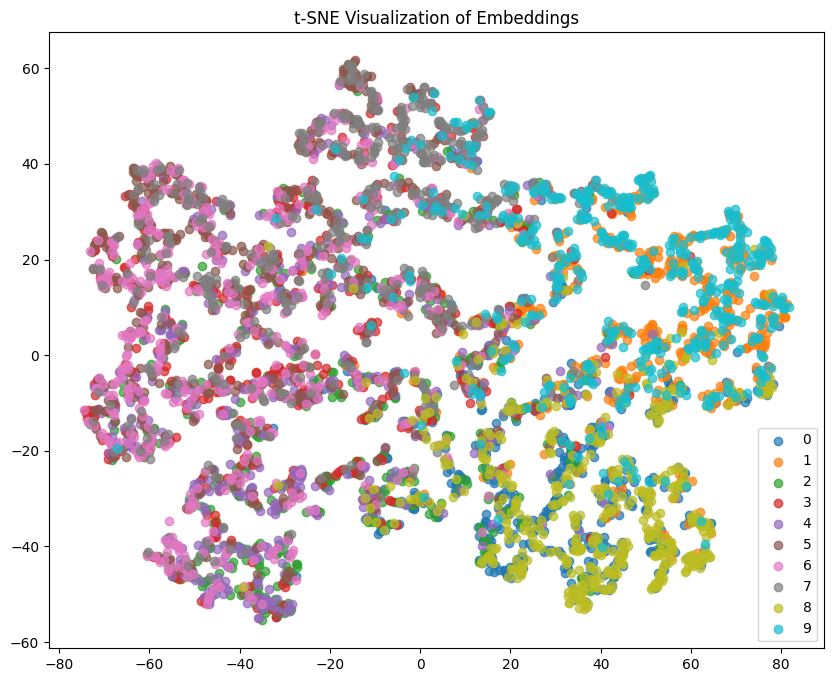

In [ ]:
plt.figure(figsize=(10, 8))
for label in set(true_labels.numpy()):
    indices = true_labels.numpy() == label
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=str(label), alpha=0.7)

plt.title("t-SNE Visualization of Embeddings")
plt.legend()
plt.show()
